# CISC/CMPE 452/COGS 400 Assignment 2 - Backpropagation (15 points)  

Please put your name and student id here

    Kieran Cosgrove, #20226841

- The notebook file has clearly marked blocks where you are expected to write code. Do not write or modify any code outside of these blocks.
- Make sure to restart and run all the cells from the beginning before submission. Do not clear out the outputs. You will only get credit for code that has been run.
- Mark will be deducted based on late policy (-1% of the course total marks per day after due date until the end date after which no assignments will be accepted)


## [Part 1 (9 points)](#Part-1)  

### Build Model1 (7 points)  
Use Pytorch to implement a three-layer Neural Network (input layer - hidden layer - output layer) and update the weights with backpropagation  
- 1. Implement forward and calculate the output (1 point)  
- 2. Calculate errors and loss (3 points)  
- 3. Update the weights with backpropagation (1 points)  
- 4. Predict function (1 point)  
- 5. Activation function (Sigmoid function) (1 point)  

### Evaluator Function (1 point)  
Implement the evaluator function with Pytorch or Numpy only   
- Evaluation metrics include confusion matrix, accuracy, recall score, precision and F1 score

### Train and Evaluate Model1 (1 point)  
Train Model1 with customized hidden size, learning rate, number of iterations and batch size  
Use the predict function to predict the labels with the test dataset  
Evaluate the prediction results  
- Evaluation metrics include confusion matrix, accuracy, recall score, precision and F1 score

## [Part 2 (6 points)](#Part-2)  

Use another machine learning framework (**scikit-learn, Tensorflow and Pytorch**) to build MLP
e.g. 
  1. https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
  2. https://www.tensorflow.org/api_docs/python/tf/keras/Sequential
  3. https://pytorch.org/tutorials/beginner/examples_nn/polynomial_nn.html#sphx-glr-beginner-examples-nn-polynomial-nn-py
  
### Build Model2-1 (2 points)  
Implement Model2-1 with the same hidden nodes and optimization function as the model in Part 1  
Train and validate model. Use the best model on validation dataset to test on the test dataset  

### Train and Evaluate Model2-1 (1 point)
Evaluate the prediction results  
- Evaluation metrics include confusion matrix, accuracy, recall score, precision and F1 score

### Build Model2-2 (2 points)  
Add one more hidden layer (2 hidden layers in total) to the model  
Describe Model2-2 (number of hidden nodes)  
Train and validate model. Use the best model on validation dataset to test on the test dataset  

### Train and Evaluate Model2-2 (1 point)
Evaluate the prediction results  
- Evaluation metrics include confusion matrix, accuracy, recall score, precision and F1 score

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST

In [2]:
# you can go to Edit - Notebook settings to select GPU under the Hardware accelerator
# check the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
# build the dataset (train, validation and test)
def load_MNIST(n_val=10000, n_sample=1000, sample=False):
    n_val = n_val
    n_sample = n_sample
    train = MNIST(root = '.', train = True, download = True)
    test = MNIST(root = '.', train = False, download = True)
    
    # data preprocessing
    x_train, x_test = train.data/255, test.data/255
    x_train = x_train.reshape(x_train.shape[0], -1)
    x_test = x_test.reshape(x_test.shape[0], -1)
    y_train = torch.nn.functional.one_hot(train.targets)
    y_test = torch.nn.functional.one_hot(test.targets)

    data_dict = {}
    if sample:
        data_dict['x_train'] = x_train[:-n_val][:n_sample]
        data_dict['y_train'] = y_train[:-n_val][:n_sample]
        data_dict['x_val'] = x_train[-n_val:][:n_sample//10]
        data_dict['y_val'] = y_train[-n_val:][:n_sample//10]
        data_dict['x_test'] = x_test[:n_sample//10]
        data_dict['y_test'] = y_test[:n_sample//10]
    else:
        data_dict['x_train'] = x_train[:-n_val]
        data_dict['y_train'] = y_train[:-n_val]
        data_dict['x_val'] = x_train[-n_val:]
        data_dict['y_val'] = y_train[-n_val:]
        data_dict['x_test'] = x_test
        data_dict['y_test'] = y_test
    return data_dict

In [4]:
# you can start with a small sample dataset by setting sample=True
data_dict = load_MNIST(sample=False)
print('Train data shape:', data_dict['x_train'].shape)
print('Train labels shape:', data_dict['y_train'].shape)
print('Validation data shape:', data_dict['x_val'].shape)
print('Validation labels shape:', data_dict['y_val'].shape)
print('Test data shape:', data_dict['x_test'].shape)
print('Test labels shape:', data_dict['y_test'].shape)

Train data shape: torch.Size([50000, 784])
Train labels shape: torch.Size([50000, 10])
Validation data shape: torch.Size([10000, 784])
Validation labels shape: torch.Size([10000, 10])
Test data shape: torch.Size([10000, 784])
Test labels shape: torch.Size([10000, 10])


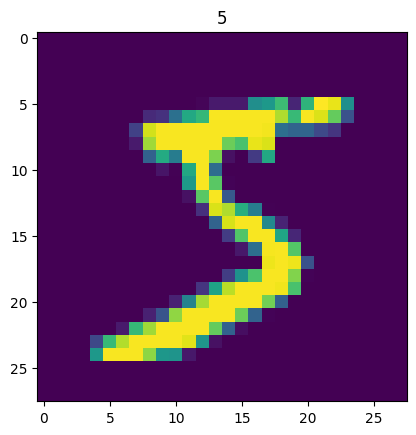

In [5]:
# plot an example
plt.imshow(data_dict['x_train'][0].reshape(28, 28))
plt.title(data_dict['y_train'][0].argmax().item())
plt.show()

In [6]:
def evaluator(y_test, y_pred):
  def confusion_matrix(y_test, y_pred):
    K = len(np.unique(y_test)) # Number of classes 
    result = np.zeros((K, K))

    for i in range(len(y_test)):
        result[y_test[i]][y_pred[i]] += 1

    return result

  def accuracy_score(y_test, y_pred):
    correct = sum(y_test == y_pred)
    total =  len(y_test)
    return correct / total

  def precision_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    return np.diag(cm) / np.sum(cm, axis = 0)

  def recall_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    return np.diag(cm) / np.sum(cm, axis = 1)

  def f1_score(y_test, y_pred):
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    return 2 * (precision * recall) / (precision + recall)

  cm = confusion_matrix(y_test, y_pred).astype(int)
  print('Confusion matrix:')
  print(cm)

  print()
  print('Accuracy: %.5f' %accuracy_score(y_test, y_pred))
  print('Precision: %.5f' %np.mean(precision_score(y_test, y_pred)))
  print('Recall: %.5f' %np.mean(recall_score(y_test, y_pred)))
  print('F1: %.5f' %np.mean(f1_score(y_test, y_pred)))

## Part 1

In [7]:
class NN(object):
    def __init__(self, learning_rate, n_iters, batch_size, hidden_size, device, dtype=torch.float32):
        self.learning_rate = learning_rate
        self.n_iters = n_iters
        self.batch_size = batch_size
        self.hidden_size = hidden_size
        self.device = device
        self.dtype = dtype
        self.history = {}
        self.history['train_acc'], self.history['val_acc'], self.history['loss'] = [], [], []
    
    # 5. activation function
    def sigmoid(self, x):
        ####################################################################################################
        # enter code here to implement the activation function
        return 1 / (1 + torch.exp(-x))
        ####################################################################################################

    def train(self, x, y, x_val, y_val, verbose=1):
        n_train = x.shape[0]
        n_val = x_val.shape[0]
        input_size = x.shape[1]
        num_classes = y.shape[1]
        
        # weight initialization
        self.W1 = torch.randn(input_size, self.hidden_size, dtype=self.dtype, device=self.device) * 0.01
        self.W2 = torch.randn(self.hidden_size, num_classes, dtype=self.dtype, device=self.device) * 0.01

        # TODO: train the weights with the input data and labels
        for i in range(self.n_iters):
            loss = 0
            data = getBatch(x, y, self.batch_size)
            for x_batch, y_batch in data:
                # 1. forward
                ####################################################################################################
                # enter code here to calculate the hidden layer output and output layer output
                hidden = self.sigmoid(torch.matmul(x_batch, self.W1)) # (batch_size, hidden_size)
                output = self.sigmoid(torch.matmul(hidden, self.W2)) # 
                ####################################################################################################

                # 2. error and loss
                ####################################################################################################
                # enter code here to calculate the output error, MSE loss, delta output and delta hidden
                output_error = y_batch - output # deviation from the true label
                loss += torch.mean(torch.square(output_error)) # MSE loss
                delta_output = output_error * output * (1 - output) # computing the derivative of the error with respect to the output
                delta_hidden = torch.matmul(delta_output, self.W2.T) * hidden * (1 - hidden) # propogating the changes to the hidden layer
                ####################################################################################################

                # 3. backward
                ####################################################################################################
                # enter code here to calculate delta weights and update the weights
                dw2 = self.learning_rate * torch.matmul(hidden.T, delta_output) # how much we need to change W2 to minimize the loss
                dw1 = self.learning_rate * torch.matmul(x_batch.T, delta_hidden) # how much we need to change W1 to minimize the loss
                
                # Update the weights
                self.W1 += dw1
                self.W2 += dw2  
                
                ####################################################################################################

            # calculate the accuracy and save the training history
            y_pred = self.predict(x)
            train_acc = torch.sum(torch.argmax(y, dim=1) == y_pred) / n_train
            self.history['train_acc'].append(train_acc)
            self.history['loss'].append(loss)
            
            y_pred = self.predict(x_val)
            val_acc = torch.sum(torch.argmax(y_val, dim=1) == y_pred) / n_val
            self.history['val_acc'].append(val_acc)
            if verbose:
                print('epoch %d, loss %.4f, train acc %.3f, validation acc %.3f'% (i + 1, loss, train_acc, val_acc))
    
    # 4. predict function 
    def predict(self, x):
        ####################################################################################################
        # enter code here to implement the predict function
        # TODO: use the trained weights to predict labels and return the predicted labels
        # remember to use torch.argmax() to return the true labels
        hidden = self.sigmoid(torch.matmul(x, self.W1))
        y_pred = self.sigmoid(torch.matmul(hidden, self.W2))
        y_pred = torch.argmax(y_pred, dim=1)
        
        ####################################################################################################
        return y_pred

def getBatch(x, y, batch_size):
    n_epoch = x.shape[0] // batch_size
    for i in range(n_epoch):
        x_batch = x[i * batch_size : (i+1) * batch_size]
        y_batch = y[i * batch_size : (i+1) * batch_size]
        yield x_batch, y_batch
    x_batch = x[(i+1) * batch_size:]
    y_batch = y[(i+1) * batch_size:]    
    yield x_batch, y_batch

In [8]:
####################################################################################################
# enter code here to train Model1
# TODO: set your desired hidden size, learning rate, number of iterations and batch size
# remeber to load the dataset to the device (e.g. data_dict['x_train'].to(device))
model = NN(learning_rate=0.01, n_iters=25, batch_size=100, hidden_size=200, device=device)
model.train(data_dict['x_train'].to(device), data_dict['y_train'].to(device), data_dict['x_val'].to(device), data_dict['y_val'].to(device), verbose=1)

####################################################################################################

epoch 1, loss nan, train acc 0.820, validation acc 0.839
epoch 2, loss nan, train acc 0.886, validation acc 0.900
epoch 3, loss nan, train acc 0.901, validation acc 0.913
epoch 4, loss nan, train acc 0.909, validation acc 0.921
epoch 5, loss nan, train acc 0.916, validation acc 0.925
epoch 6, loss nan, train acc 0.921, validation acc 0.928
epoch 7, loss nan, train acc 0.926, validation acc 0.932
epoch 8, loss nan, train acc 0.929, validation acc 0.936
epoch 9, loss nan, train acc 0.933, validation acc 0.939
epoch 10, loss nan, train acc 0.936, validation acc 0.942
epoch 11, loss nan, train acc 0.939, validation acc 0.945
epoch 12, loss nan, train acc 0.942, validation acc 0.948
epoch 13, loss nan, train acc 0.944, validation acc 0.950
epoch 14, loss nan, train acc 0.946, validation acc 0.952
epoch 15, loss nan, train acc 0.949, validation acc 0.954
epoch 16, loss nan, train acc 0.950, validation acc 0.955
epoch 17, loss nan, train acc 0.952, validation acc 0.956
epoch 18, loss nan, tra

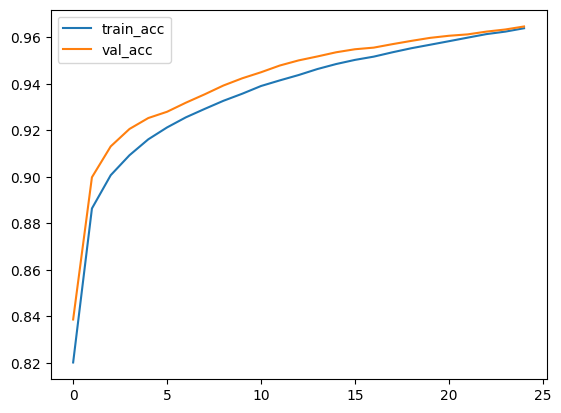

In [9]:
plt.plot(model.history['train_acc'], label='train_acc')
plt.plot(model.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

In [10]:
####################################################################################################
# enter code here to evaluate Model1 with test set
# TODO: use the trained Model1 to predict the labels of test set and evaluate the results with the evaluator

# It's worth noting that it is a dataset with multi-class labels (0-9).
# The evaluator method is designed for binary classification. So accuracy could be skewed.

# Use the model to make predictions on the test data
y_pred_raw = model.predict(data_dict['x_test'].to(device))

# Transfer the predictions back to CPU memory from GPU memory (if applicable) and convert to numpy
y_pred = y_pred_raw.cpu()

# Extract the actual classes from test labels 
y_test_classes = data_dict['y_test'].argmax(dim=1)

#Call the evaluator function with the correct arguments
evaluator(y_test_classes, y_pred)


####################################################################################################

Confusion matrix:
[[ 964    0    1    2    0    3    7    1    2    0]
 [   0 1115    3    2    0    1    5    2    7    0]
 [   7    1  987    4    7    0    7    7    9    3]
 [   0    0    7  978    0    3    3    7    9    3]
 [   1    1    4    0  930    0   11    3    4   28]
 [  10    1    1   13    1  835   12    1   12    6]
 [   7    3    0    1    4    8  930    0    5    0]
 [   1   11   16    4    3    0    0  976    2   15]
 [   4    1    2    8    4    4    5    4  939    3]
 [   7    6    0   12   12    5    1    9    4  953]]

Accuracy: 0.96070
Precision: 0.96061
Recall: 0.96027
F1: 0.96035


## Part 2

### Model2-1

In [11]:
####################################################################################################
# enter code here to implement Model2-1
from sklearn.neural_network import MLPClassifier
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import precision_score
# from sklearn.metrics import recall_score
# from sklearn.metrics import f1_score
model = MLPClassifier(max_iter=10, hidden_layer_sizes=(100), activation='logistic')
####################################################################################################

In [12]:
####################################################################################################
# enter code here to train Model2-1
model.fit(data_dict['x_train'], data_dict['y_train'].argmax(dim=1))
####################################################################################################

/Users/kierancosgrove/opt/anaconda3/envs/CMPE452/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(activation='logistic', hidden_layer_sizes=100, max_iter=10)

In [13]:
####################################################################################################
# enter code here to evaluate Model2-1
y_pred = model.predict(data_dict['x_test'])
evaluator(data_dict['y_test'].argmax(dim=1), torch.tensor(y_pred))

####################################################################################################

Confusion matrix:
[[ 963    0    1    2    0    3    7    2    2    0]
 [   0 1119    3    1    1    1    3    2    5    0]
 [   4    1  991    6    5    1    4    8   10    2]
 [   0    0    8  967    0    9    0   11   11    4]
 [   1    0    6    1  941    0    6    1    3   23]
 [   6    1    3   28    2  825    8    1   11    7]
 [   6    3    2    2    6    6  928    0    5    0]
 [   0    8   22    7    2    0    0  969    0   20]
 [   3    4    4   16    6    5    6    8  918    4]
 [   6    7    1   13   16    7    1    9    2  947]]

Accuracy: 0.95680
Precision: 0.95675
Recall: 0.95617
F1: 0.95639


### Model2-2

In [14]:
####################################################################################################
# enter code here to implement Model2-2
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(max_iter=10, hidden_layer_sizes=(100, 100), activation='logistic')

####################################################################################################

In [15]:
####################################################################################################
# enter code here to train Model2-2
model.fit(data_dict['x_train'], data_dict['y_train'].argmax(dim=1))
####################################################################################################

/Users/kierancosgrove/opt/anaconda3/envs/CMPE452/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(activation='logistic', hidden_layer_sizes=(100, 100), max_iter=10)

In [16]:
####################################################################################################
# enter code here to evaluate Model2-2
y_pred = model.predict(data_dict['x_test'])
evaluator(data_dict['y_test'].argmax(dim=1), torch.tensor(y_pred))
####################################################################################################

Confusion matrix:
[[ 967    0    3    2    0    5    2    1    0    0]
 [   0 1119    2    1    0    1    4    2    6    0]
 [   4    3 1001    2    3    1    4    7    7    0]
 [   0    1    7  979    0    8    0    8    6    1]
 [   0    1    5    0  945    0    8    4    2   17]
 [   3    2    0    9    2  858    8    2    4    4]
 [   8    4    1    1    5    9  925    0    5    0]
 [   1    8   13    7    0    1    0  989    2    7]
 [   4    3    5    8    3    7    4    6  931    3]
 [   4    6    0   11   18   10    1   10    1  948]]

Accuracy: 0.96620
Precision: 0.96598
Recall: 0.96591
F1: 0.96591
